# Colab에 Google Drive 마운트

In [15]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 5.2 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp -rf /content/drive/MyDrive/colab/didimdol/* .
!unzip  /content/dataset/dataset.zip -d ./dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./dataset/archive/casting_data/casting_data/train/def_front/cast_def_0_5881.jpeg  
  inflating: ./dataset/__MACOSX/archive/casting_data/casting_data/train/def_front/._cast_def_0_5881.jpeg  
  inflating: ./dataset/archive/casting_data/casting_data/train/def_front/cast_def_0_4639.jpeg  
  inflating: ./dataset/__MACOSX/archive/casting_data/casting_data/train/def_front/._cast_def_0_4639.jpeg  
  inflating: ./dataset/archive/casting_data/casting_data/train/def_front/cast_def_0_958.jpeg  
  inflating: ./dataset/__MACOSX/archive/casting_data/casting_data/train/def_front/._cast_def_0_958.jpeg  
  inflating: ./dataset/archive/casting_data/casting_data/train/def_front/cast_def_0_7015.jpeg  
  inflating: ./dataset/__MACOSX/archive/casting_data/casting_data/train/def_front/._cast_def_0_7015.jpeg  
  inflating: ./dataset/archive/casting_data/casting_data/train/def_front/cast_def_0_5028.jpeg  
  inflating: ./dataset/__MACOSX/archive/casting_data/casti

#Colab 터미널 사용 세팅

In [ ]:
!pip install kora
from kora import console
console.start()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 5.0 MB/s 
     |████████████████████████████████| 59 kB 9.2 MB/s 



#라이브러리 로드

In [1]:
# import model.efficientv2 as efficient
# import model.inceptionv4 as inception
import timm
from utils.imageloader import ImageDataset

In [5]:
import os
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import logging
from time import time

#로그 설정

In [6]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(message)s')
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

#학습 디바이스 확인

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Load on {device}')

Load on cuda


#학습데이터 로드

In [8]:
trn_dataset = ImageDataset('dataset/archive/casting_data/casting_data/train')
val_dataset = ImageDataset('dataset/archive/casting_data/casting_data/test')

trn_dataloader = torch.utils.data.DataLoader(trn_dataset,
                                                batch_size=128,
                                                shuffle=True,
                                                num_workers=6)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                                batch_size=128,
                                                shuffle=False,
                                                num_workers=6)
logger.info(f'trn: {len(trn_dataset)}, val: {len(val_dataset)}')

2022-05-26 09:39:39,397 - trn: 6633, val: 715


#학습데이터 이미지 정보

In [9]:
x = []
y = []
for key, value in trn_dataset.labels_map.items():
    x.append(key)
    y.append(len(list(filter(lambda x : x == value, trn_dataset.label_to_idx))))

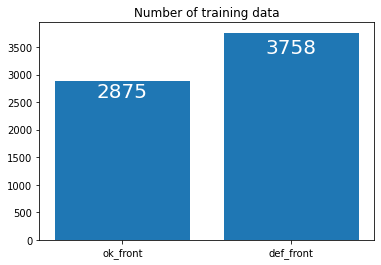

In [10]:
import matplotlib.pyplot as plt

plt.bar(x, y)
for index, value in enumerate(y):
    plt.text(index, value - (value*0.1), str(value), color='white', size = 20, horizontalalignment="center")

plt.title('Number of training data')
plt.show()

In [11]:
defect = list(filter(lambda x : x.find('ok') == -1, trn_dataset.file_path))
normal = list(filter(lambda x : x.find('ok') != -1, trn_dataset.file_path))

In [12]:
import cv2
sample_image = cv2.imread(normal[0])
sample_image.shape

(300, 300, 3)

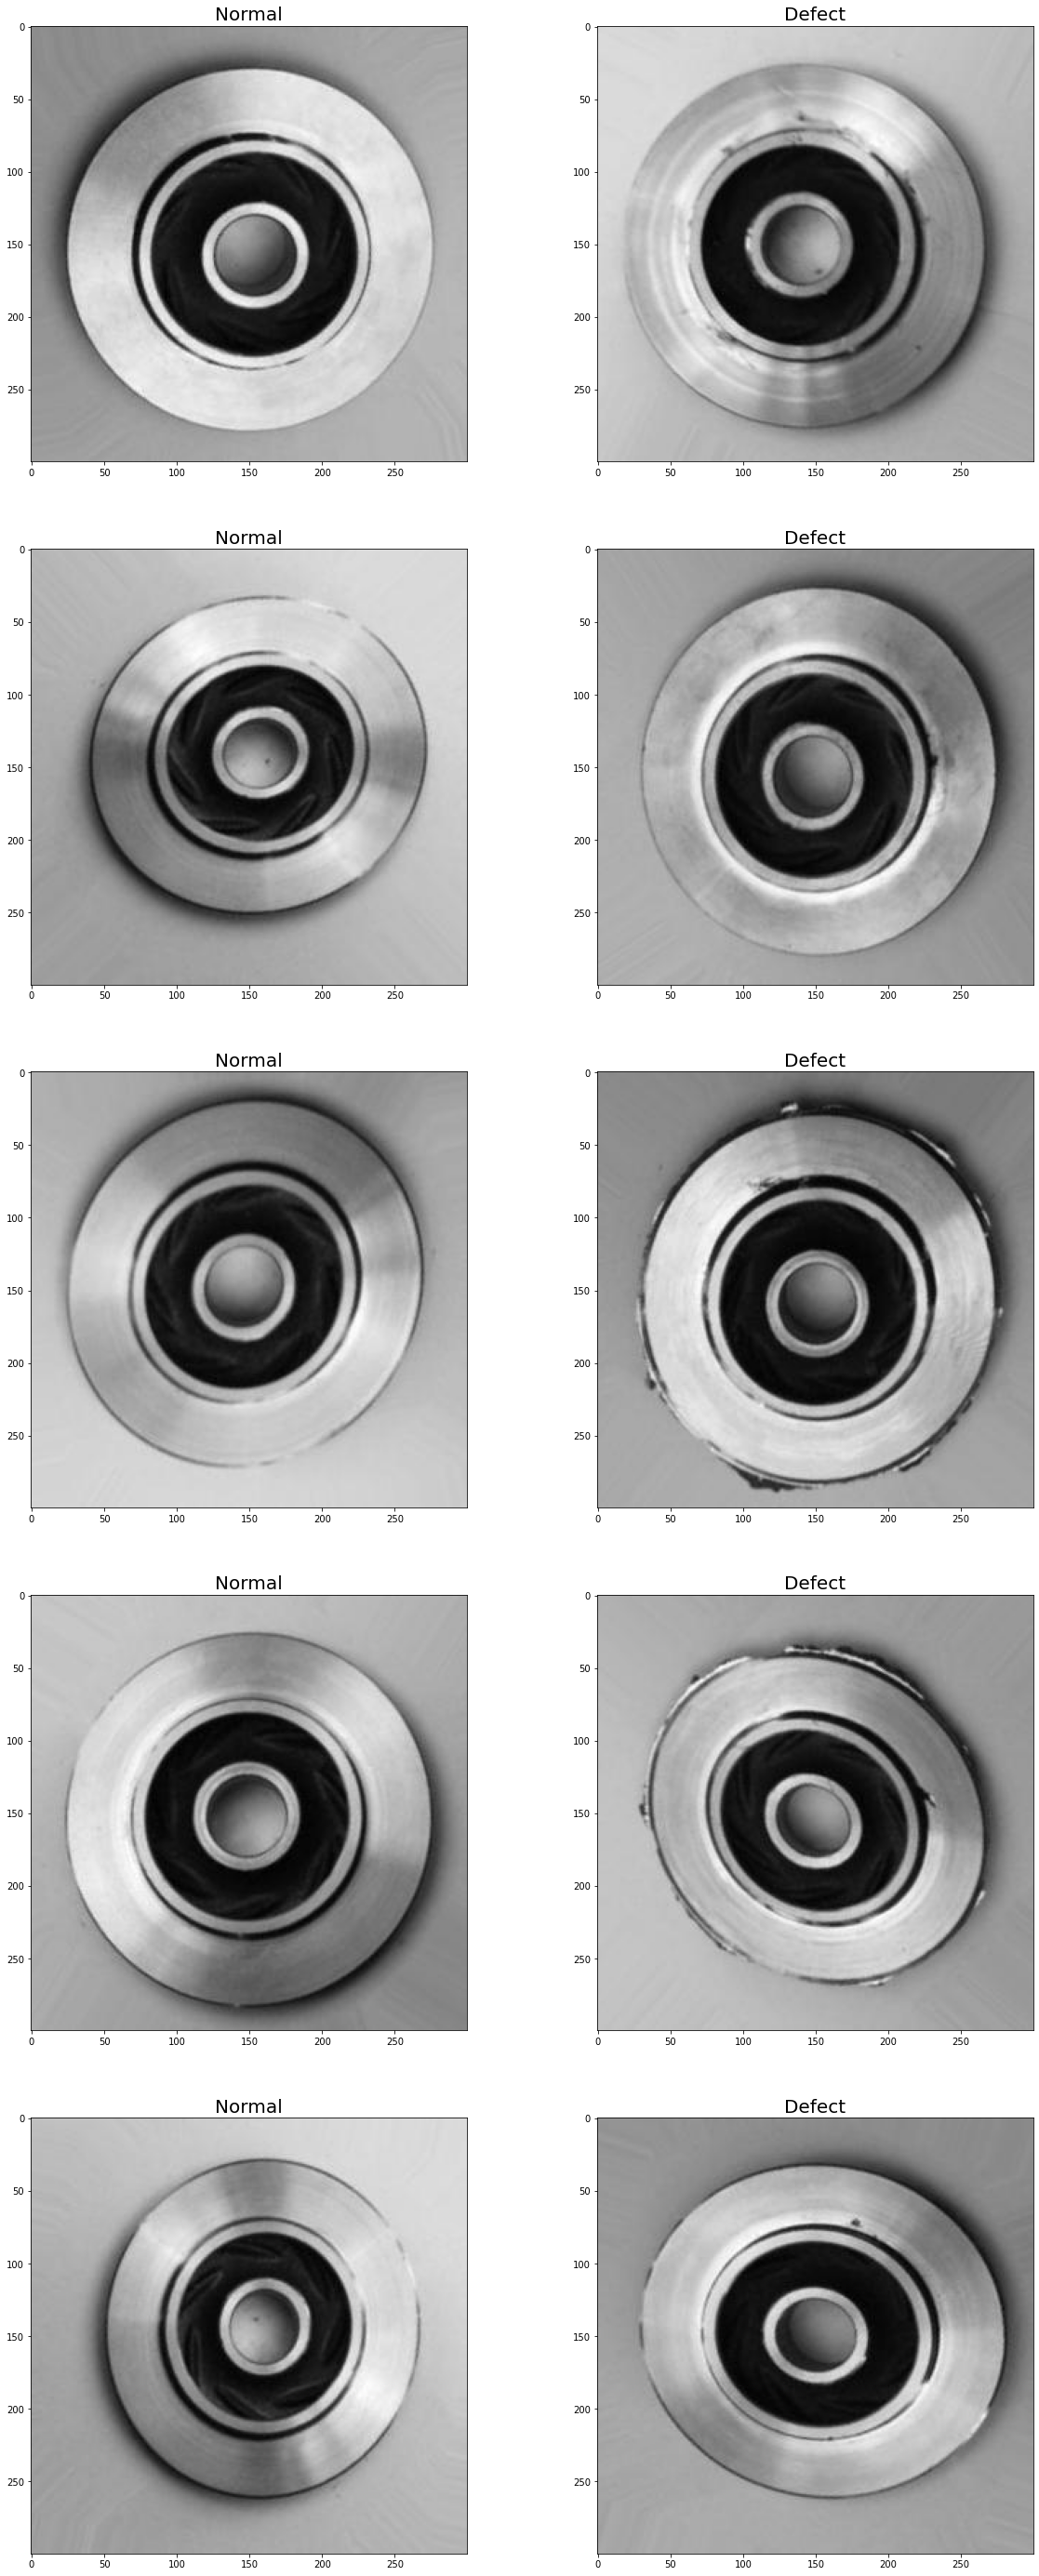

In [13]:
fig = plt.figure(figsize=(20, 50))
rows = 5
cols = 2

for idx in range(0, rows):
    img1 = cv2.imread(normal[idx])
    img2 = cv2.imread(defect[idx])

    ax1 = fig.add_subplot(rows, cols, idx*2+1)
    ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax1.set_title('Normal', size = 20)

    ax2 = fig.add_subplot(rows, cols, idx*2+2)
    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    ax2.set_title('Defect', size = 20)
 
plt.show()

#모델 세팅 (inception v4)

In [14]:
model = timm.create_model('inception_v4', pretrained=False, num_classes = 1)
#model.half()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

#모델학습 내용

In [15]:
def fit(model, dataloader, half = False):
    loss = .0
    acc = .0
    correct = 0
    start_time = time()
    
    for data, target in dataloader:
        data = data.to(device)
        if half :
            data = data.half()
        target = target.to(device)
        output = model(data)
        output = output.squeeze(dim=1)
        loss = criterion(output, target)
        
        if model.training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss += loss
        
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        correct += output.eq(target).int().sum()

    acc = (correct/len(dataloader.dataset))
    loss = loss/len(dataloader.dataset)
    logger.info("{}, duration:{:6.1f}s, acc:{:.4f}, loss:{:.4f}".format(('trn' if model.training else 'val'), 
                                                                         time()-start_time, 
                                                                         acc, 
                                                                         loss ))
    return float(loss), float(acc)

In [16]:
epochs = 20

trn_loss = []
trn_acc = []
val_loss = []
val_acc = []

half = False

for epoch in range(1, epochs+1):
    logger.info(f'epoch {epoch}')

    model.train()
    loss, acc = fit(model, trn_dataloader, half=half)

    trn_loss.append(loss)
    trn_acc.append(acc)

    model.eval()
    with torch.no_grad():
        loss, acc = fit(model, val_dataloader, half=half)

        if len(val_acc) > 0 and max(val_acc) < acc:
            torch.save(model.state_dict(), f"./model_state_dict_{epoch}.pt")

        val_loss.append(loss)
        val_acc.append(acc)
    
    if(epochs % 10 == 0):
        torch.save(
            {
                "model": "effnetv2_s",
                "epoch": epoch,
                "model_state_dict" : model.state_dict(),
                "optimizer_state_dict" : optimizer.state_dict(),
                "cost" : trn_loss[len(trn_loss)-1],
            },
            f"./checkpoint-{epoch}.pt"
        )

2022-05-26 09:39:46,873 - epoch 1
2022-05-26 09:40:51,467 - trn, duration:  64.5s, acc:0.6848, loss:0.0001
2022-05-26 09:40:54,320 - val, duration:   2.8s, acc:0.8140, loss:0.0008
2022-05-26 09:40:54,671 - epoch 2
2022-05-26 09:41:59,319 - trn, duration:  64.6s, acc:0.9026, loss:0.0000
2022-05-26 09:42:02,126 - val, duration:   2.8s, acc:0.8755, loss:0.0001
2022-05-26 09:42:02,757 - epoch 3
2022-05-26 09:43:07,416 - trn, duration:  64.6s, acc:0.9509, loss:0.0000
2022-05-26 09:43:10,249 - val, duration:   2.8s, acc:0.9175, loss:0.0000
2022-05-26 09:43:10,879 - epoch 4
2022-05-26 09:44:15,567 - trn, duration:  64.6s, acc:0.9691, loss:0.0000
2022-05-26 09:44:18,293 - val, duration:   2.7s, acc:0.9091, loss:0.0004
2022-05-26 09:44:18,625 - epoch 5
2022-05-26 09:45:23,186 - trn, duration:  64.5s, acc:0.9795, loss:0.0000
2022-05-26 09:45:25,999 - val, duration:   2.8s, acc:0.9860, loss:0.0000
2022-05-26 09:45:26,710 - epoch 6
2022-05-26 09:46:31,246 - trn, duration:  64.4s, acc:0.9834, loss:

In [17]:
trn_loss = [float(v) for v in trn_loss]
trn_acc = [float(v) for v in trn_acc]
val_loss = [float(v) for v in val_loss]
val_acc = [float(v) for v in val_acc]

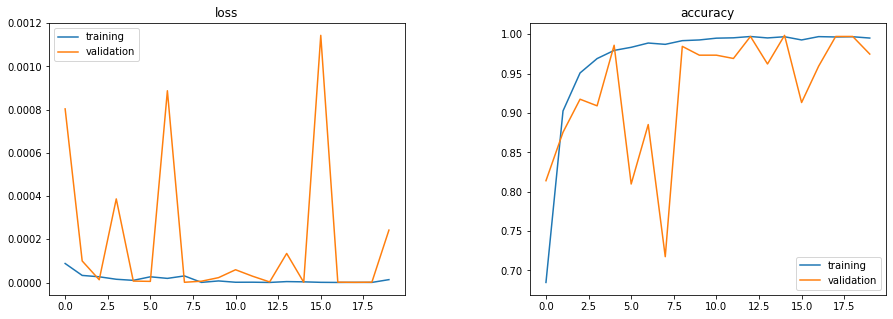

In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(trn_loss)
plt.plot(val_loss)
plt.legend(['training', 'validation'])
plt.title('loss')

plt.subplot(1, 2, 2)
plt.plot(trn_acc)
plt.plot(val_acc)
plt.legend(['training', 'validation'])
plt.title('accuracy')

plt.subplots_adjust(wspace=0.35)

plt.show()

* GPU : Tesla P100
* batch size 128 일때, 메모리 사용량 : 8.5G
* 모델 기본 메모리 사용량 : 700mb

#CPU Inference 테스트

In [19]:
device='cpu'
model = model.to(device)
model.eval()
with torch.no_grad():
    loss, acc = fit(model, val_dataloader)
    val_loss.append(loss)
    val_acc.append(acc)

2022-05-26 10:03:13,650 - val, duration:  50.1s, acc:0.9748, loss:0.0002


In [27]:
715/50

9.407894736842104